In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import concatenate_datasets

In [2]:
# Optional: Disable symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the full IMDB dataset
dataset = load_dataset("imdb")

# Print label distribution for better understanding
print("Training dataset label distribution:", dataset["train"].features["label"].names)
print("Test dataset label distribution:", dataset["test"].features["label"].names)

Using device: cuda
Training dataset label distribution: ['neg', 'pos']
Test dataset label distribution: ['neg', 'pos']


In [18]:
# Separate the positive and negative samples from the training and test sets
positive_train_data = dataset["train"].filter(lambda example: example["label"] == 1)
negative_train_data = dataset["train"].filter(lambda example: example["label"] == 0)

positive_test_data = dataset["test"].filter(lambda example: example["label"] == 1)
negative_test_data = dataset["test"].filter(lambda example: example["label"] == 0)



# Balance the datasets by selecting an equal number of samples from both classes
balanced_train_data = concatenate_datasets([positive_train_data.select(range(12500)), negative_train_data.select(range(12500))])
balanced_test_data = concatenate_datasets([positive_test_data.select(range(2000)), negative_test_data.select(range(2000))])


In [19]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing...")
tokenized_train = balanced_train_data.map(tokenize_function, batched=True)
tokenized_test = balanced_test_data.map(tokenize_function, batched=True)
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Tokenizing...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [21]:
# DataLoader
train_loader = DataLoader(tokenized_train, batch_size=64, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=64,  shuffle= False)

In [22]:
# Model definition
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.fc(cls_output)


In [23]:
model = BERTClassifier(BertModel.from_pretrained("bert-base-uncased")).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scaler = GradScaler(device)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):  # 20 epochs
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)  # shape: (B, 1)

        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=total_loss / (total / 8), acc=correct / total)

    # Record training metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().unsqueeze(1).to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")


Epoch 1:   1%|          | 3/391 [00:22<47:34,  7.36s/it, acc=0.474, loss=0.0902]

In [11]:
# Evaluation of the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

In [12]:
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3750


In [13]:
# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(all_labels, all_preds))


Classification Report (Test Data):
              precision    recall  f1-score   support

         0.0       0.40      0.50      0.44         4
         1.0       0.33      0.25      0.29         4

    accuracy                           0.38         8
   macro avg       0.37      0.38      0.37         8
weighted avg       0.37      0.38      0.37         8



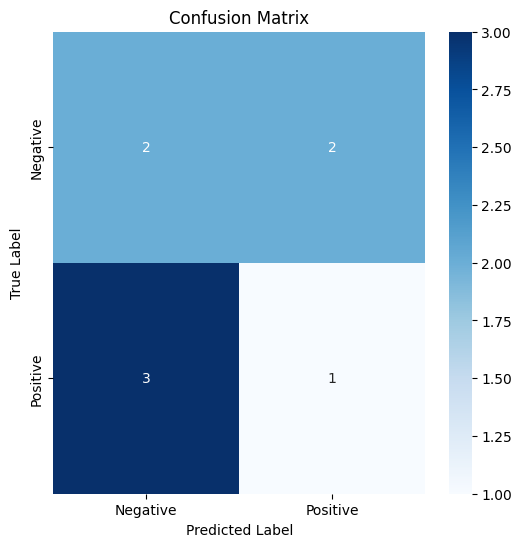

In [14]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0.0, 1.0])

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

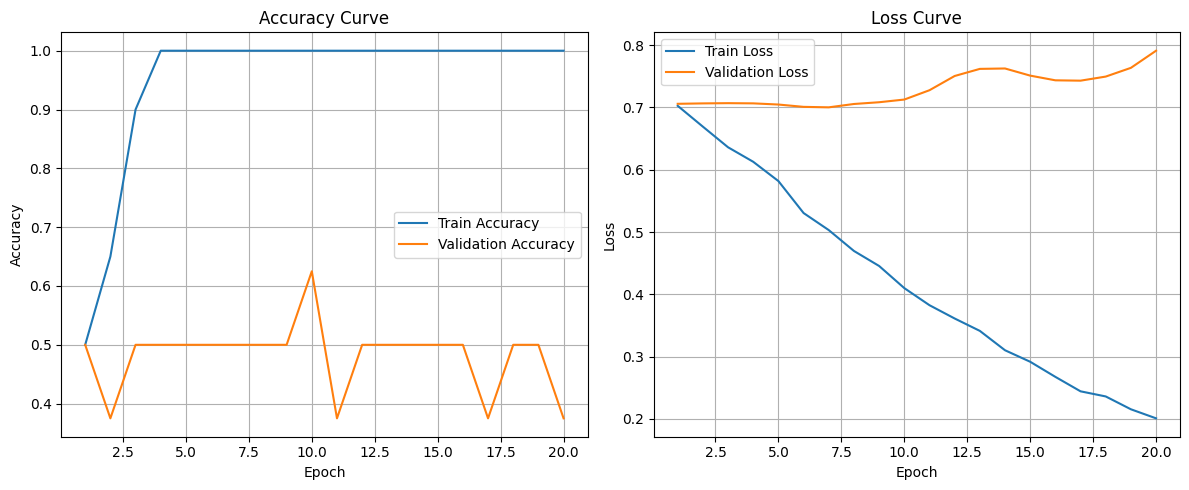

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)  # dynamically set length

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
if len(val_losses) == len(train_losses):  # Safe check
    plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
if len(val_accuracies) == len(train_accuracies):
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Define a function to predict sentiment of custom text input
def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Tokenize input
        encoding = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=256
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Predict
        output = model(input_ids, attention_mask)
        prob = torch.sigmoid(output)

        # Result
        sentiment = "Positive" if prob.item() > 0.5 else "Negative"
        print(f"\nInput Text: {text}")
        print(f"Predicted Sentiment: {sentiment} (Confidence: {prob.item():.2f})")

# Example: Try predicting sentiment for new input
user_input = "Every one should watch the movie at least once"
predict_sentiment(user_input, model, tokenizer, device)

user_input = "This movie was boring and didn't make sense."
predict_sentiment(user_input, model, tokenizer, device)



Input Text: Every one should watch the movie at least once
Predicted Sentiment: Negative (Confidence: 0.32)

Input Text: This movie was boring and didn't make sense.
Predicted Sentiment: Negative (Confidence: 0.40)
